# Reference orientation 
#### This notebook showcases functions used for reference orientation analysis. 
#### That is, determining the dominant orientation of gradients in a keypoint's local neighborhood.

## Imports

In [1]:
# Handles relative import
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import const
import octaves as octaves_lib
import keypoints as keypoints_lib
import reference_orientation as reference_lib

## Find a Keypoint

In [2]:
img = cv2.imread('../images/box_in_scene.png', flags=cv2.IMREAD_GRAYSCALE)
img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
img = img[0:300, 100:400]
octave_idx = 4
gauss_octaves = octaves_lib.build_gaussian_octaves(img)
gauss_octave = gauss_octaves[octave_idx]
dog_octave = octaves_lib.build_dog_octave(gauss_octave)
extrema = octaves_lib.find_dog_extrema(dog_octave)
keypoint_coords = keypoints_lib.find_keypoints(extrema, dog_octave)
coord = keypoint_coords[0]
print(f'Octave {octave_idx} has {len(keypoint_coords)} keypoints')

Octave 4 has 8 keypoints


## Keypoint Local Neighborhood Gradients
For further details, see function `assign_reference_orientations` in `reference_orientation.py`.

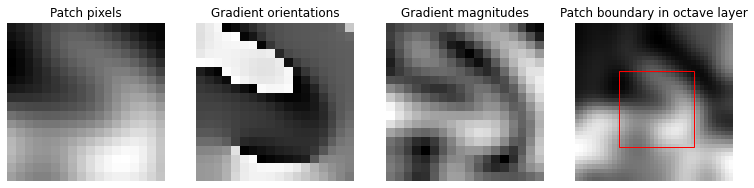

In [3]:
magnitudes, orientations = reference_lib.gradients(gauss_octave)
orientations_bins = reference_lib.orientation_to_bin_idx(orientations)
octave_shape = gauss_octave.shape
pixel_dist = const.min_pixel_dist * (2 ** octave_idx)

s, y, x = coord.round().astype(int)
absolute_coord = np.array([x * pixel_dist, y * pixel_dist])
sigma = octaves_lib.absolute_sigma(octave_idx, s)
patch_width = reference_lib.reference_patch_width(octave_idx, sigma)
patch_with_half = round(patch_width / 2)

if reference_lib.patch_in_frame(coord, patch_with_half, octave_shape):
    patch = gauss_octave[s,
                         y - patch_with_half: y + patch_with_half,
                         x - patch_with_half: x + patch_with_half]
    orientation_patch = orientations[s,
                                     y - patch_with_half: y + patch_with_half,
                                     x - patch_with_half: x + patch_with_half]
    orientation_patch_bins = orientations_bins[s,
                                               y - patch_with_half: y + patch_with_half,
                                               x - patch_with_half: x + patch_with_half]
    magnitude_patch = magnitudes[s,
                                 y - patch_with_half: y + patch_with_half,
                                 x - patch_with_half: x + patch_with_half]


fig, axs = plt.subplots(1, 4, figsize=(13, 4))
rect = patches.Rectangle(coord[1:] - patch_with_half, patch_width, patch_width, linewidth=1, edgecolor='r', facecolor='none')

axs[0].imshow(patch, cmap='gray')
axs[1].imshow(orientation_patch, cmap='gray')
axs[2].imshow(magnitude_patch, cmap='gray')
axs[3].imshow(gauss_octave[s], cmap='gray')
axs[3].add_patch(rect)
axs[0].title.set_text('Patch pixels')
axs[1].title.set_text('Gradient orientations')
axs[2].title.set_text('Gradient magnitudes')
axs[3].title.set_text('Patch boundary in octave layer')
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')

plt.show()

## Gradient Directions

Text(0.5, 1.0, 'Image gradients')

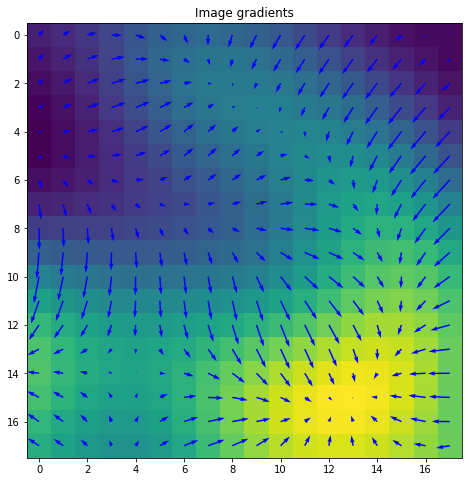

In [4]:
rows, cols = patch.shape
nr_pixels = rows * cols
y_idxs = np.arange(rows)
x_idxs = np.arange(cols)
xs, ys = np.meshgrid(x_idxs, y_idxs)

length = magnitude_patch.flatten()

v_xs = length
v_ys = [0] * len(v_xs)

# Angles are inverted, because the y axis is flipped by imshow, meaning that 
# arrows that should point down point up. The minus operator solves this axis inversion. 
angles = np.rad2deg(-orientation_patch).flatten()
plt.figure(figsize=(8, 8))
plt.imshow(patch)
plt.quiver(xs, ys, v_xs, v_ys, angles=angles, color='b')
plt.title('Image gradients')

## Orientation Histogram Maxima
A keypoint's **reference orientation** is equal to that of the peak(s) of the smoothed gradient orientation histogram.    
For further details, see function `assign_reference_orientations` in `reference_orientation.py`.

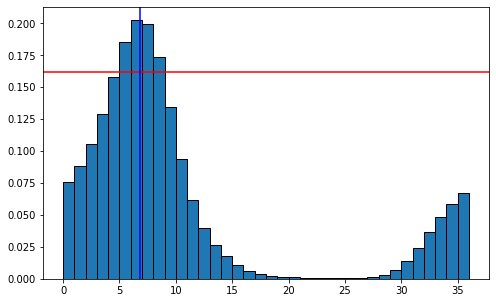

The maximum bin at index 6.33 represents a reference orientation of 1.10 radians or 63.28 degrees


In [5]:
patch_shape = magnitude_patch.shape
center_offset = [coord[1] - y, coord[2] - x]
weights = reference_lib.weighting_matrix(center_offset, patch_shape, octave_idx, sigma, const.reference_locality)
contribution = weights * magnitude_patch
hist, bin_edges = np.histogram(orientation_patch_bins, bins=const.nr_bins, range=(0, const.nr_bins), weights=contribution)
hist = reference_lib.smoothen_histogram(hist)
dominant_orientations = reference_lib.find_histogram_peaks(hist)


fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor="black", align="edge")
ax.axhline(y=0.8 * np.max(hist), color='r', linestyle='-')

max_bins = list()
for maximum in dominant_orientations:
    loc = (maximum / (2 * np.pi)) * const.nr_bins
    max_bins.append(loc)
    ax.axvline(x=loc + 0.5, color='b', linestyle='-')

plt.show()

print(f'The maximum bin at index {loc:.2f} represents a reference orientation of {maximum:.2f} radians or {np.rad2deg(maximum):.2f} degrees') 
